# Time Series Analysis with ehrdata and PyPOTS
ehrdata supports the extraction of data from the OMOP Common Data Model, as well as prepared datasets such as the Physionet 2012 Challenge.

Once data is in the ehrdata format, ehrapy can operate on the data with
- exploratory data analysis
- utility functions for time series (ep.timeseries coming soon)
- ...

From ehrdata, also fast deep-learning based time series analysis can be done using e.g. [PyPOTS](https://github.com/WenjieDu/PyPOTS).
PyPOTS is a Python toolkit/library for reality-centric machine/deep learning and data mining on partially-observed time series, including SOTA neural network models for scientific analysis tasks of imputation/classification/clustering/forecasting/anomaly detection/cleaning on incomplete industrial (irregularly-sampled) multivariate TS with NaN missing values.

## Example case: From any dataset in OMOP CDM 5.4 to applying DL for ...

### Load Libraries

In [1]:
#! pip install pypots

In [2]:
import duckdb
import ehrdata as ed
import pypots
import ehrapy as ep

/Users/eljas.roellin/Documents/ehrapy_workspace/ehrapy_venv_oct/lib/python3.11/site-packages/pypots/nn/modules/reformer/local_attention.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/Users/eljas.roellin/Documents/ehrapy_workspace/ehrapy_venv_oct/lib/python3.11/site-packages/pypots/nn/modules/reformer/local_attention.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



### Load and extract data

In [3]:
con_gi = duckdb.connect(database=":memory:", read_only=False)
ed.dt.synthea27nj_omop(
    con_gi,
)
edata = ed.io.omop.setup_obs(
    con_gi,
    observation_table="person_observation_period",
)
edata = ed.io.omop.setup_variables(
    edata=edata,
    backend_handle=con_gi,
    data_tables=["measurement"],
    data_field_to_keep=["value_as_number"],
    interval_length_number=20,
    interval_length_unit="day",
    num_intervals=10,
    concept_ids="all",
    aggregation_strategy="last",
    enrich_var_with_feature_info=True,
    enrich_var_with_unit_info=True,
)

: 

: 

In [70]:
edata

EHRData object with n_obs x n_var = 28 x 132, and a timeseries of 10 steps.
             shape of .X: (0, 0) 
             shape of .r: (28, 132, 10) 

### Fit Model

In [ ]:
saits = pypots.imputation.saits.SAITS(
    n_steps=10,
    n_features=edata.shape[1],
    n_layers=1,
    d_model=10,
    n_heads=2,
    d_k=10,
    d_v=10,
    d_ffn=10,
)

saits.fit({"X": edata.r.transpose(0, 2, 1)})

In [63]:
predictions = saits.predict({"X": edata.r.transpose(0, 2, 1)}, return_latent_vars=True)
edata.obsm["saits_latent"] = predictions["latent_vars"]["combining_weights"][:, :, -1]

### Show 2D representation

... storing 'concept_id_unit' as categorical
... storing 'concept_id_unit' as categorical


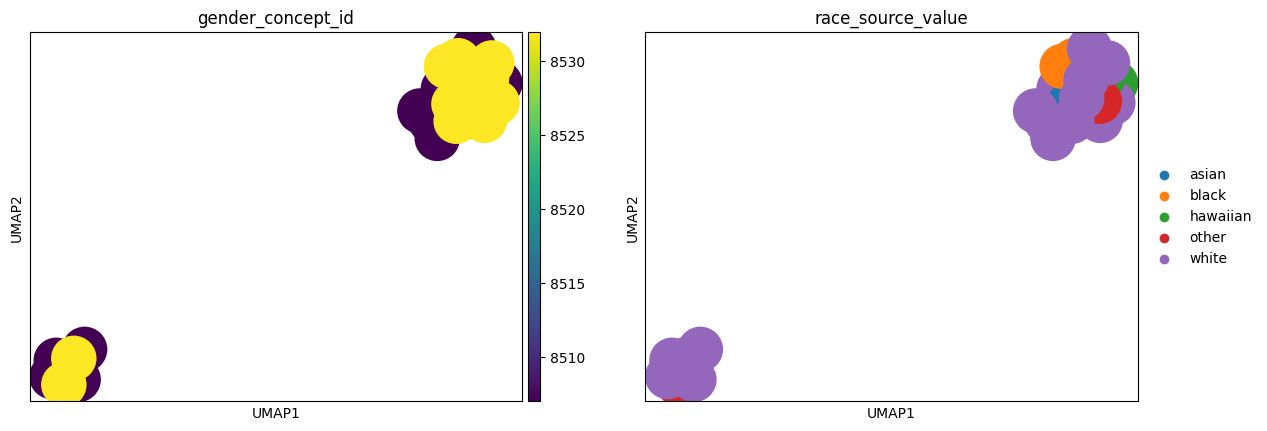

In [69]:
ep.pp.neighbors(edata, use_rep="saits_latent")
ep.tl.umap(edata)
ep.pl.umap(edata, color=["gender_concept_id", "race_source_value"])